# Capstone Project

## Please open with nbviewer to see the map

In [1]:
# import the libraries
import os
import numpy as np 

import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json 
from dotenv import load_dotenv 

from geopy.geocoders import Nominatim

import requests 
from pandas.io.json import json_normalize 

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

import folium 
import wget

import warnings 
warnings.filterwarnings('ignore') 

## 1. Download and Explore Dataset


In [2]:
wget.download('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json','newyork_data.json') 

100% [............................................................................] 115774 / 115774

'newyork_data (2).json'

#### Load and explore the data


Next, let's load the data.


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

#### Filter data frame for Brooklyn

In [4]:
Brooklyn_data = neighborhoods[neighborhoods['Borough'] == 'Brooklyn'].reset_index(drop=True)
Brooklyn_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471


Let's get the geographical coordinates of Brooklyn.


In [5]:
address = 'Brooklyn, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Brooklyn are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Brooklyn are 40.6501038, -73.9495823.


In [6]:
# create map of Brooklyn using latitude and longitude values
map_Brooklyn = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(Brooklyn_data['Latitude'], Brooklyn_data['Longitude'], Brooklyn_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Brooklyn)  
    
map_Brooklyn

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.


#### Define Foursquare Credentials and Version


In [7]:
# for hiding the credential
load_dotenv('4S.env')
CLIENT_ID = os.getenv('CLIENT_ID')
CLIENT_SECRET = os.getenv('CLIENT_SECRET')

In [8]:
CLIENT_ID = CLIENT_ID 
CLIENT_SECRET = CLIENT_SECRET 
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

#### Let's explore the first neighborhood in our dataframe.


Get the neighborhood's name.


In [9]:
Brooklyn_data.loc[0, 'Neighborhood']

'Bay Ridge'

Get the neighborhood's latitude and longitude values.


In [10]:
neighborhood_latitude = Brooklyn_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = Brooklyn_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = Brooklyn_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Bay Ridge are 40.625801065010656, -74.03062069353813.


#### Now, let's get the top 100 venues that are in Bay Ridge within a radius of 500 meters.


First, let's create the GET request URL. Name your URL **url**.


In [11]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

Send the GET request and examine the resutls


In [12]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f97995d2be1a37c28bd904a'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Bay Ridge',
  'headerFullLocation': 'Bay Ridge, Brooklyn',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 81,
  'suggestedBounds': {'ne': {'lat': 40.63030106951066,
    'lng': -74.02470273356597},
   'sw': {'lat': 40.62130106051065, 'lng': -74.03653865351028}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b895827f964a5206c2d32e3',
       'name': 'Pilo Arts Day Spa and Salon',
       'location': {'address': '8412 3rd Ave',
        'lat': 40.62474788273414,
        'lng': -74.03059056940135,
        'labeledLatL

In [13]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a _pandas_ dataframe.


In [14]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Pilo Arts Day Spa and Salon,Spa,40.624748,-74.030591
1,Bagel Boy,Bagel Shop,40.627896,-74.029335
2,Pegasus Cafe,Breakfast Spot,40.623168,-74.031186
3,Leo's Casa Calamari,Pizza Place,40.624200,-74.030931
4,Cocoa Grinder,Juice Bar,40.623967,-74.030863


And how many venues were returned by Foursquare?


In [15]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

81 venues were returned by Foursquare.


<a id='item2'></a>


## 2. Explore Neighborhoods in Brooklyn


In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called _Brooklyn_venues_.


In [17]:
Brooklyn_venues = getNearbyVenues(names=Brooklyn_data['Neighborhood'],
                                   latitudes=Brooklyn_data['Latitude'],
                                   longitudes=Brooklyn_data['Longitude']
                                  )

Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Sea Gate
Downtown
Boerum Hill
Prospect Lefferts Gardens
Ocean Hill
City Line
Bergen Beach
Midwood
Prospect Park South
Georgetown
East Williamsburg
North Side
South Side
Ocean Parkway
Fort Hamilton
Ditmas Park
Wingate
Rugby
Remsen Village
New Lots
Paerdegat Basin
Mill Basin
Fulton Ferry
Vinegar Hill
Weeksville
Broadway Junction
Dumbo
Homecrest
Highland Park
Madison
Erasmus


#### Let's check the size of the resulting dataframe


In [18]:
print(Brooklyn_venues.shape)
Brooklyn_venues.head()

(2763, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Ridge,40.625801,-74.030621,Pilo Arts Day Spa and Salon,40.624748,-74.030591,Spa
1,Bay Ridge,40.625801,-74.030621,Bagel Boy,40.627896,-74.029335,Bagel Shop
2,Bay Ridge,40.625801,-74.030621,Pegasus Cafe,40.623168,-74.031186,Breakfast Spot
3,Bay Ridge,40.625801,-74.030621,Leo's Casa Calamari,40.624200,-74.030931,Pizza Place
4,Bay Ridge,40.625801,-74.030621,Cocoa Grinder,40.623967,-74.030863,Juice Bar


Let's check how many venues were returned for each neighborhood


In [19]:
Brooklyn_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bath Beach,46,46,46,46,46,46
Bay Ridge,81,81,81,81,81,81
Bedford Stuyvesant,28,28,28,28,28,28
Bensonhurst,36,36,36,36,36,36
Bergen Beach,7,7,7,7,7,7
Boerum Hill,90,90,90,90,90,90
Borough Park,22,22,22,22,22,22
Brighton Beach,43,43,43,43,43,43
Broadway Junction,20,20,20,20,20,20


#### Let's find out how many unique categories can be curated from all the returned venues


In [20]:
print('There are {} uniques categories.'.format(len(Brooklyn_venues['Venue Category'].unique())))

There are 288 uniques categories.


## 3. Analyze Each Neighborhood

In [21]:
# one hot encoding
Brooklyn_onehot = pd.get_dummies(Brooklyn_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Brooklyn_onehot['Neighborhood'] = Brooklyn_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Brooklyn_onehot.columns[-1]] + list(Brooklyn_onehot.columns[:-1])
Brooklyn_onehot = Brooklyn_onehot[fixed_columns]

Brooklyn_onehot.head()

,Yoga Studio,Accessories Store,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundromat,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoors & Recreation,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roller Rink,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toy / Game Store,Trail,Turkish Restaurant,Used Books

And let's examine the new dataframe size.


In [22]:
Brooklyn_onehot.shape

(2763, 288)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category


In [23]:
Brooklyn_grouped = Brooklyn_onehot.groupby('Neighborhood').mean().reset_index()
Brooklyn_grouped

,Neighborhood,Yoga Studio,Accessories Store,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundromat,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoors & Recreation,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roller Rink,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toy / Game Store,Trail,Turkish Restaurant,Used Books

#### Let's confirm the new size


In [24]:
Brooklyn_grouped.shape

(70, 288)

#### Let's print each neighborhood along with the top 5 most common venues


In [25]:
num_top_venues = 5

for hood in Brooklyn_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Brooklyn_grouped[Brooklyn_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bath Beach----
                  venue  freq
0              Pharmacy  0.04
1  Fast Food Restaurant  0.04
2       Bubble Tea Shop  0.04
3  Cantonese Restaurant  0.04
4    Chinese Restaurant  0.04


----Bay Ridge----
                 venue  freq
0   Italian Restaurant  0.07
1                  Spa  0.06
2          Pizza Place  0.05
3     Greek Restaurant  0.04
4  American Restaurant  0.04


----Bedford Stuyvesant----
          venue  freq
0   Coffee Shop  0.11
1          Café  0.07
2   Pizza Place  0.07
3           Bar  0.07
4  Gourmet Shop  0.04


----Bensonhurst----
                venue  freq
0  Chinese Restaurant  0.11
1  Italian Restaurant  0.08
2      Ice Cream Shop  0.06
3    Sushi Restaurant  0.06
4          Donut Shop  0.06


----Bergen Beach----
             venue  freq
0  Harbor / Marina  0.29
1       Playground  0.14
2   Baseball Field  0.14
3             Park  0.14
4     Hockey Field  0.14


----Boerum Hill----
          venue  freq
0   Coffee Shop  0.06
1  Dance Studio  

                  venue  freq
0              Pharmacy   0.1
1  Caribbean Restaurant   0.1
2   American Restaurant   0.1
3            Donut Shop   0.1
4           Bus Station   0.1


----Sunset Park----
                       venue  freq
0         Mexican Restaurant  0.08
1  Latin American Restaurant  0.08
2                       Bank  0.08
3                     Bakery  0.08
4          Mobile Phone Shop  0.08


----Vinegar Hill----
                      venue  freq
0                Food Truck  0.17
1                      Café  0.07
2               Coffee Shop  0.07
3               Art Gallery  0.07
4  Bike Rental / Bike Share  0.07


----Weeksville----
            venue  freq
0  Discount Store  0.12
1       Juice Bar  0.06
2  History Museum  0.06
3     Gas Station  0.06
4      Donut Shop  0.06


----Williamsburg----
            venue  freq
0     Coffee Shop  0.09
1      Bagel Shop  0.06
2     Yoga Studio  0.03
3  Breakfast Spot  0.03
4    Burger Joint  0.03


----Windsor Terrace----
   

#### Let's put that into a _pandas_ dataframe


First, let's write a function to sort the venues in descending order.


In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.


In [27]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Brooklyn_grouped['Neighborhood']

for ind in np.arange(Brooklyn_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Brooklyn_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bath Beach,Pharmacy,Donut Shop,Gas Station,Bubble Tea Shop,Cantonese Restaurant,Italian Restaurant,Fast Food Restaurant,Chinese Restaurant,Pizza Place,Dessert Shop
1,Bay Ridge,Italian Restaurant,Spa,Pizza Place,American Restaurant,Bar,Greek Restaurant,Bagel Shop,Hookah Bar,Thai Restaurant,Ice Cream Shop
2,Bedford Stuyvesant,Coffee Shop,Pizza Place,Café,Bar,Deli / Bodega,Tiki Bar,Park,Cocktail Bar,New American Restaurant,Bus Stop
3,Bensonhurst,Chinese Restaurant,Italian Restaurant,Donut Shop,Ice Cream Shop,Sushi Restaurant,Park,Pizza Place,Shabu-Shabu Restaurant,Sporting Goods Shop,Smoke Shop
4,Bergen Beach,Harbor / Marina,Playground,Hockey Field,Baseball Field,Athletics & Sports,Park,Food,Flower Shop,Food & Drink Shop,Flea Market


<a id='item4'></a>


## 4. Cluster Neighborhoods


Run _k_-means to cluster the neighborhood into 3 clusters.

In [28]:
# set number of clusters
kclusters = 3

Brooklyn_grouped_clustering = Brooklyn_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Brooklyn_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 0, 0, 0, 0, 0, 2, 2, 2, 0])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.


In [29]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Brooklyn_merged = Brooklyn_data

# merge Brooklyn_grouped with Brooklyn_data to add latitude/longitude for each neighborhood
Brooklyn_merged = Brooklyn_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Brooklyn_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Brooklyn,Bay Ridge,40.625801,-74.030621,0,Italian Restaurant,Spa,Pizza Place,American Restaurant,Bar,Greek Restaurant,Bagel Shop,Hookah Bar,Thai Restaurant,Ice Cream Shop
1,Brooklyn,Bensonhurst,40.611009,-73.995180,0,Chinese Restaurant,Italian Restaurant,Donut Shop,Ice Cream Shop,Sushi Restaurant,Park,Pizza Place,Shabu-Shabu Restaurant,Sporting Goods Shop,Smoke Shop
2,Brooklyn,Sunset Park,40.645103,-74.010316,2,Mobile Phone Shop,Mexican Restaurant,Bank,Bakery,Latin American Restaurant,Pizza Place,Gym,Fried Chicken Joint,Deli / Bodega,Ice Cream Shop
3,Brooklyn,Greenpoint,40.730201,-73.954241,0,Bar,Pizza Place,Coffee Shop,Cocktail Bar,Record Shop,Yoga Studio,Mexican Restaurant,French Restaurant,Nail Salon,Deli / Bodega
4,Brooklyn,Gravesend,40.595260,-73.973471,0,Lounge,Pizza Place,Bakery,Chinese Restaurant,Gym,Italian Restaurant,Cosmetics Shop,Farmers Market,Men's Store,Baseball Field


Finally, let's visualize the resulting clusters


In [38]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Brooklyn_merged['Latitude'], Brooklyn_merged['Longitude'], Brooklyn_merged['Neighborhood'], Brooklyn_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>


## 5. Examine Clusters


#### Cluster 1


In [31]:
cluster_1 = Brooklyn_merged.loc[Brooklyn_merged['Cluster Labels'] == 0, Brooklyn_merged.columns[[1] + list(range(5, Brooklyn_merged.shape[1]))]]
cluster_1.reset_index(drop=True, inplace=True)

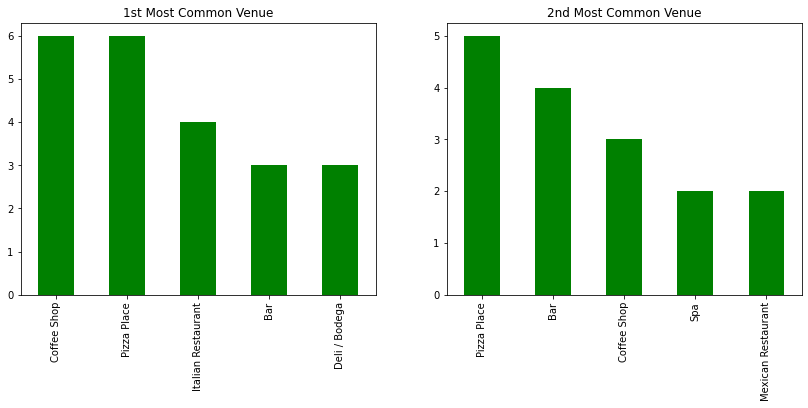

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
cluster_1['1st Most Common Venue'].value_counts()[:5].plot(kind='bar', color = 'green', ax=ax1)
cluster_1['2nd Most Common Venue'].value_counts()[:5].plot(kind='bar', color = 'green', ax=ax2)
ax1.title.set_text('1st Most Common Venue')
ax2.title.set_text('2nd Most Common Venue')
plt.show()

#### Cluster 2


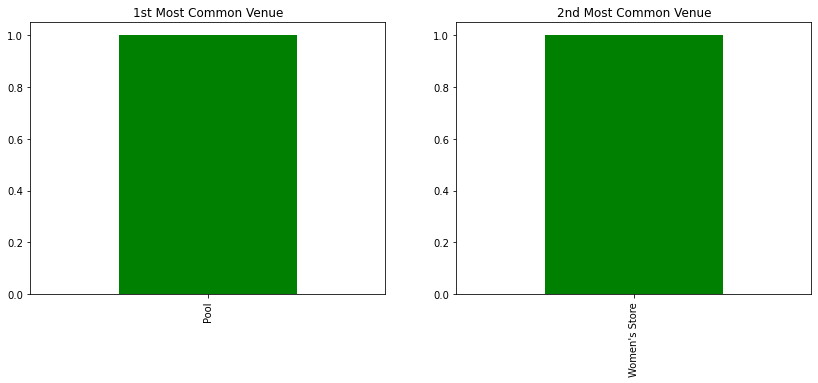

In [33]:
cluster_2 = Brooklyn_merged.loc[Brooklyn_merged['Cluster Labels'] == 1, Brooklyn_merged.columns[[1] + list(range(5, Brooklyn_merged.shape[1]))]]
cluster_2.reset_index(drop=True, inplace=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
cluster_2['1st Most Common Venue'].value_counts()[:5].plot(kind='bar', color = 'green', ax=ax1)
cluster_2['2nd Most Common Venue'].value_counts()[:5].plot(kind='bar', color = 'green', ax=ax2)
ax1.title.set_text('1st Most Common Venue')
ax2.title.set_text('2nd Most Common Venue')
plt.show()

#### Cluster Not-Italian


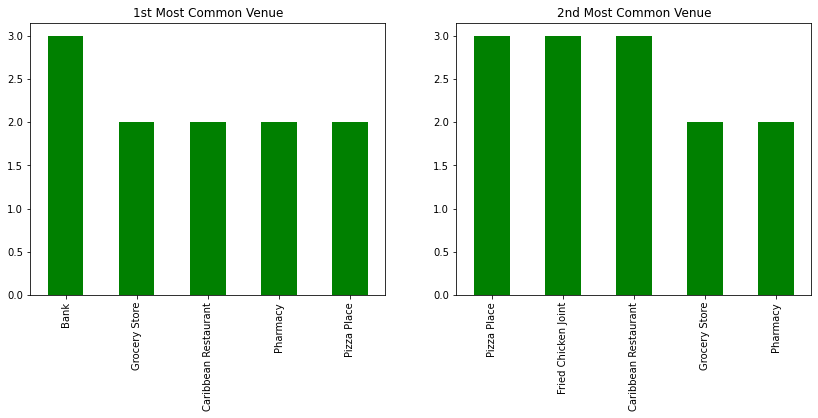

In [34]:
cluster_3 = Brooklyn_merged.loc[Brooklyn_merged['Cluster Labels'] == 2, Brooklyn_merged.columns[[1] + list(range(5, Brooklyn_merged.shape[1]))]]
cluster_3.reset_index(drop=True, inplace=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
cluster_3['1st Most Common Venue'].value_counts()[:5].plot(kind='bar', color = 'green', ax=ax1)
cluster_3['2nd Most Common Venue'].value_counts()[:5].plot(kind='bar', color = 'green', ax=ax2)
ax1.title.set_text('1st Most Common Venue')
ax2.title.set_text('2nd Most Common Venue')
plt.show()

## Ideal location for italian cuisine
For the graphs above, we know that cluster 1 is the best location to start a business in Italian Cuisines

In [35]:
# Ideal location for italian cuisine
cluster_italian = Brooklyn_merged.loc[Brooklyn_merged['Cluster Labels'] == 0]

In [36]:
list(cluster_italian['Neighborhood'])

['Bay Ridge',
 'Bensonhurst',
 'Greenpoint',
 'Gravesend',
 'Sheepshead Bay',
 'Manhattan Terrace',
 'Crown Heights',
 'Kensington',
 'Windsor Terrace',
 'Prospect Heights',
 'Williamsburg',
 'Bushwick',
 'Bedford Stuyvesant',
 'Brooklyn Heights',
 'Cobble Hill',
 'Carroll Gardens',
 'Red Hook',
 'Gowanus',
 'Fort Greene',
 'Park Slope',
 'Manhattan Beach',
 'Dyker Heights',
 'Gerritsen Beach',
 'Marine Park',
 'Clinton Hill',
 'Downtown',
 'Boerum Hill',
 'Prospect Lefferts Gardens',
 'Ocean Hill',
 'Bergen Beach',
 'Midwood',
 'East Williamsburg',
 'North Side',
 'South Side',
 'Ocean Parkway',
 'Fort Hamilton',
 'Fulton Ferry',
 'Vinegar Hill',
 'Dumbo',
 'Madison']

In [37]:
# create map
map_cluster_italians = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lon, poi, cluster in zip(cluster_italian['Latitude'], cluster_italian['Longitude'], cluster_italian['Neighborhood'], cluster_italian['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_cluster_italians)
       
map_cluster_italians